### part0:imports

In [1]:
%matplotlib inline

from tqdm import tqdm
import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
from scipy.stats import wilcoxon, mannwhitneyu, linregress
import math

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection
from collections import Counter
import torch

import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        reload(params)
        defs = params.random_walk_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'random_walk')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)
    print('Done')

import warnings
warnings.filterwarnings("ignore")


M1_spikes
84
PMd_spikes
211
Done


### Get data

In [2]:
import random_walk.defs as defs
reload(defs)

def get_full_random_walk_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList['MCx'].items():
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    allDFs_exec_MCx = []
    for animal, session in full_list_MCx:
        path = root/'random_walk'/animal/session
        df_ = defs.prep_general(dt.load_pyal_data(path))

        #separate into reaches
        df_ = defs.get_reaches_df(df_)
        df_['reach_id'] = range(len(df_))

        #subset center-out trials
        df_ = df_[df_.center_dist < defs.subset_radius]
        df_ = df_.reset_index()

        #execution epoch
        for col in df_.columns:  #TODO: placeholder to prevent bug in pyaldata
            if 'unit_guide' in col:
                df_ = df_.drop([col], axis = 1)
        df_ = pyal.add_movement_onset(df_)
        allDFs_MCx.append(df_)

        df_ = pyal.restrict_to_interval(df_, epoch_fun=defs.exec_epoch)
        allDFs_exec_MCx.append(df_)

        # print(len(df_))
        
    return full_list_MCx, allDFs_MCx, allDFs_exec_MCx

In [3]:
MCx_list, allDFs_MCx, allDFs_exec_MCx = get_full_random_walk_data()

In [4]:
import random_walk.defs as defs
reload(defs)

ref_file = 'Chewie_RT_CS_2016-10-21.mat'
ref_i = [y for x,y in MCx_list].index(ref_file)

ex_file = 'Mihili_RT_VR_2014-01-15.mat'
ex_i = [y for x,y in MCx_list].index(ex_file)

df1 = allDFs_exec_MCx[ref_i]
df2 = allDFs_exec_MCx[ex_i]

In [5]:
len(np.unique(df1.target_group.values))

65

(-10.0, 10.0)

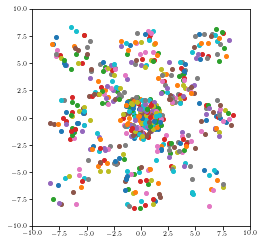

In [6]:
df1.head()

df1_ = allDFs_MCx[ref_i]

plt.figure()
for pos in df1_.pos:
    plt.scatter(pos[0,0], pos[0,1])

plt.gca().set_aspect(1)
plt.xlim([-10,10])
plt.ylim([-10,10])


#### Get paired dfs

In [7]:
ref_file = 'Chewie_RT_CS_2016-10-21.mat'
ref_i = [y for x,y in MCx_list].index(ref_file)
df1 = allDFs_exec_MCx[ref_i]

Mihili_files = GoodDataList['MCx']['Mihili']
MrT_files = GoodDataList['MCx']['MrT']
comparison_files = Mihili_files + MrT_files

paired_dfs = []
for ex_file in comparison_files:
    print(ex_file)
    # ex_file = 'Mihili_RT_VR_2014-01-15.mat'
    ex_i = [y for x,y in MCx_list].index(ex_file)
    df2 = allDFs_exec_MCx[ex_i]

    #subset dataframes with matched reaches
    df1_idx, df2_idx = defs.get_matched_reaches_idx(df1, df2)
    df1_subset = df1.iloc[df1_idx]
    df2_subset = df2.iloc[df2_idx]

    #get dataframes from whole-trial data
    df1_ = pd.DataFrame({'reach_id':df1_subset.reach_id}).merge(allDFs_MCx[ref_i])
    df2_ = pd.DataFrame({'reach_id':df2_subset.reach_id}).merge(allDFs_MCx[ex_i])

    #set target ids
    print(len(df1_) - (df1_.target_group.values == df2_.target_group.values).sum(), 'diff target groups')
    df1_.target_group = df2_.target_group.values 
    df1_['target_id'] = df1_.target_group.values
    df2_['target_id'] = df2_.target_group.values

    #only keep target groups with enough trials
    counter = Counter(df1_.target_group)
    subset_target_groups = [k for k, c in counter.items() if c >= defs.min_trials_per_target]
    df1_ = df1_[df1_.target_group.isin(subset_target_groups)]
    df2_ = df2_[df2_.target_group.isin(subset_target_groups)]
    print(len(subset_target_groups))

    paired_dfs.append((ex_file, df1_, df2_))
    

Mihili_RT_VR_2014-01-16.mat
122 diff target groups
21
Mihili_RT_FF_2014-02-21.mat
131 diff target groups
22
Mihili_RT_VR_2014-01-14.mat
136 diff target groups
28
Mihili_RT_FF_2014-02-14.mat
125 diff target groups
26
Mihili_RT_VR_2014-01-15.mat
145 diff target groups
28
Mihili_RT_FF_2014-02-24.mat
122 diff target groups
20
MrT_RT_VR_2013-09-06.mat
270 diff target groups
26
MrT_RT_FF_2013-08-30.mat
121 diff target groups
16
MrT_RT_VR_2013-09-04.mat
162 diff target groups
14
MrT_RT_FF_2013-08-20.mat
96 diff target groups
14
MrT_RT_FF_2013-08-22.mat
152 diff target groups
29
MrT_RT_VR_2013-09-10.mat
135 diff target groups
28


In [81]:
[x[0] for x in paired_dfs]

['Mihili_RT_FF_2014-02-24.mat',
 'Mihili_RT_VR_2014-01-14.mat',
 'Mihili_RT_FF_2014-02-14.mat',
 'Mihili_RT_VR_2014-01-16.mat',
 'Mihili_RT_FF_2014-02-21.mat',
 'Mihili_RT_VR_2014-01-15.mat',
 'MrT_RT_VR_2013-09-10.mat',
 'MrT_RT_VR_2013-09-06.mat',
 'MrT_RT_VR_2013-09-04.mat',
 'MrT_RT_FF_2013-08-22.mat',
 'MrT_RT_FF_2013-08-30.mat',
 'MrT_RT_FF_2013-08-20.mat']

#### Perform CCA

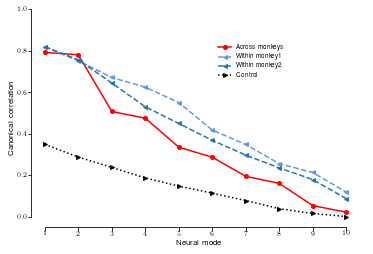

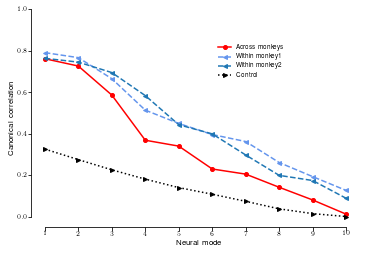

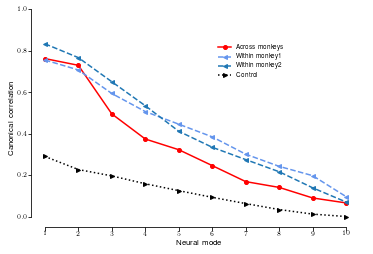

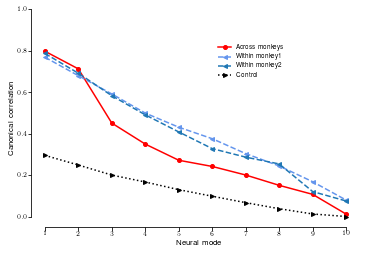

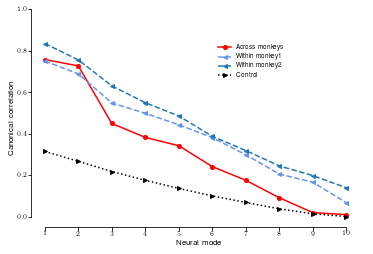

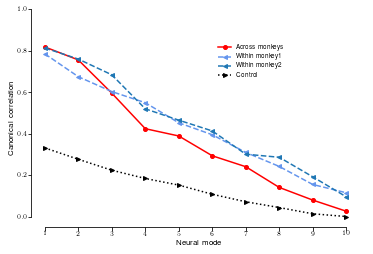

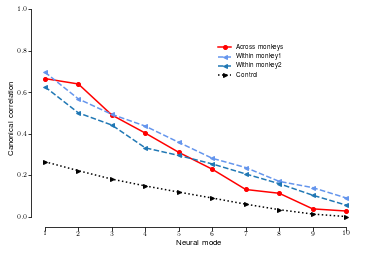

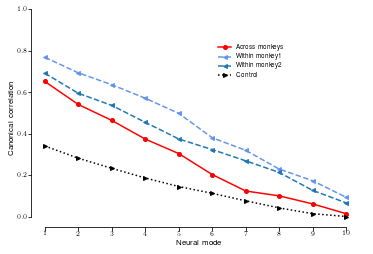

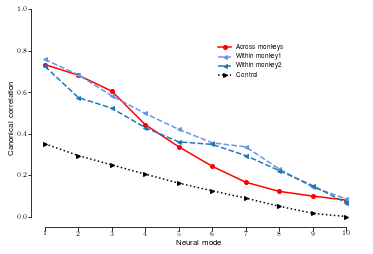

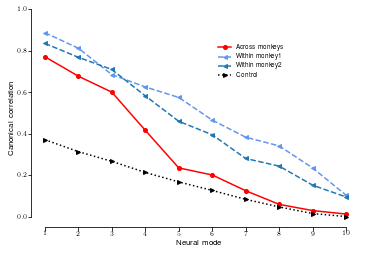

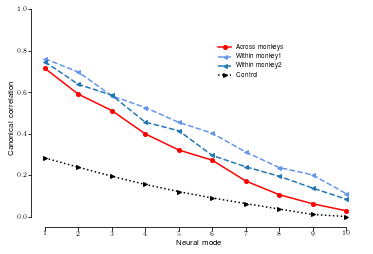

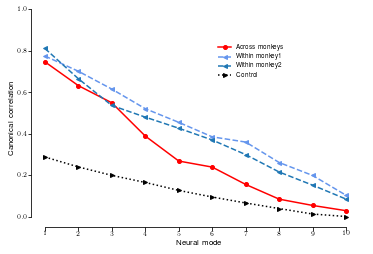

In [8]:
for ex_file, df1_, df2_ in paired_dfs:
    subset_target_groups = np.unique(df1_.target_group)

    #perform cca ################################################
    AllData1, AllData2 = defs.get_paired_data_arrays(df1_, df2_, epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
    # print(AllData1.shape) #session x target_groups x trials x time x modes
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T
        
    # lower bound
    len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))
    AllDataL1 = defs._get_data_array(df1_, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    AllDataL2 = defs._get_data_array(df2_, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllDataL1.shape,AllDataL2.shape),axis=0)
    CCsL=[]
    for sessionData1,sessionData2 in zip(AllDataL1,AllDataL2):
        r = []
        for n in range(params.n_iter * 10):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T
        
    # upper bound
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for session, sessionData in enumerate([AllData1[0], AllData2[0]]):
        r = []
        for n in range(params.n_iter * 10):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # plotting
    fig, ax = plt.subplots()
    x_ = np.arange(1,defs.n_components+1)
    ax.plot(x_, allCCs, color=params.colors.MainCC, marker = 'o', label=f'Across monkeys')
    ax.plot(x_, CCsU[:,0], color=params.colors.UpperCC, marker = '<', ls='--', label=f'Within monkey1')
    ax.plot(x_, CCsU[:,1], marker = '<', ls='--', label=f'Within monkey2')
    ax.plot(x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':', label=f'Control')


    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    # ax.set_title(f'{defs.areas[2]} Alignment')
    ax.legend(loc=(.55,.67))
    ax.set_ylabel('Canonical correlation')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,defs.n_components])
    ax.spines['left'].set_bounds([0,1])

    info = '_'.join([ex_file[:-4], str(len(subset_target_groups)), str(defs.n_angle_groups), str(defs.min_trials_per_target), str(defs.match_mse_cutoff_perc)])
    plt.savefig("figures/cca_"+info+'.pdf', format= 'pdf')

#### subset targets

In [19]:
redo = True
import random
import itertools
from tqdm.auto import tqdm

subset_CCs = []
for ex_file, df1_, df2_ in paired_dfs:
    # if ex_file != 'Mihili_RT_VR_2014-01-14.mat': continue

    #perform cca ################################################
    AllData1, AllData2 = defs.get_paired_data_arrays(df1_, df2_, epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
    # print(AllData1.shape) #session x target_groups x trials x time x modes
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T

    #get saved ccs
    info = '_'.join([ex_file[:-4], str(len(subset_target_groups)), str(defs.n_angle_groups), str(defs.min_trials_per_target), str(defs.match_mse_cutoff_perc)])
    pathPickle = root / 'random-walk-pickles'/ f'cca_subset_targets_{info}.p'

    if os.path.exists(pathPickle) and not redo:
        #load file
        with open(pathPickle, 'rb') as f:
            allCCs_subset = pickle.load(f)
    else: 
        target_groups = np.unique(df1_.target_group)
        n_target_groups = len(target_groups)

        #remove n target groups
        allCCs_subset = []
        for n in tqdm(range(2,n_target_groups)):
            allCCs_subset_ = []
            comb = list(itertools.combinations(range(n_target_groups), n))
            # print(n, len(comb))
            comb = random.sample(comb, min(len(comb),10000)) #do max 10000 combos
            for target_idx in comb:
                AllData1_ = AllData1[:, target_idx,:,:,:]
                AllData2_ = AllData2[:, target_idx,:,:,:]

                for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
                    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
                    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
                    allCCs_subset_.append(dt.canoncorr(data1, data2))
            allCCs_subset.append(np.array(allCCs_subset_).T) 
        
        with open(pathPickle, 'wb') as f:
            pickle.dump(allCCs_subset, f)

    # # plotting
    # fig, ax = plt.subplots()
    # x_ = np.arange(1,defs.n_components+1)

    # colors = utility.get_colors(n_target_groups, 'plasma')
    # for i,ccs in enumerate(allCCs_subset):
    #     utility.shaded_errorbar(ax, x_, ccs, color=colors[i], marker = 'o', label=f'Across monkeys, {i+2} targets')
    
    # ax.plot(x_, allCCs, color=colors[-1], marker = 'o', label=f'Across monkeys, {n_target_groups} (all) targets')

    # ax.set_ylim([-.05,1])
    # ax.set_xlim([.6,defs.n_components+.6])
    # ax.set_xlabel('Neural mode')
    # ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    # # ax.set_title(f'{defs.areas[2]} Alignment')
    # ax.legend(loc=(.55,.67))
    # ax.set_ylabel('Canonical correlation')

    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_bounds([1,defs.n_components])
    # ax.spines['left'].set_bounds([0,1])

    # info = '_'.join([ex_file[:-4], str(len(subset_target_groups)), str(defs.n_angle_groups), str(defs.min_trials_per_target), str(defs.match_mse_cutoff_perc)])
    # plt.savefig("figures/cca_subset_targets_"+info+'.pdf', format= 'pdf')

    subset_CCs.append(allCCs_subset)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

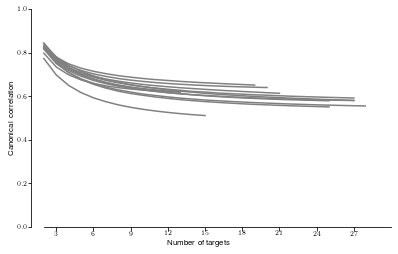

In [79]:
session_colors = utility.get_colors(len(subset_CCs))
fig, ax = plt.subplots()

for i, allCCs_subset in enumerate(subset_CCs):
    all_mean_ccs = [np.mean(x[:4],axis = 0) for x in allCCs_subset]
    mean_ccs = [np.mean(x) for x in all_mean_ccs]

    n_target_groups = len(mean_ccs)+2
    x = range(2, n_target_groups)
    colors = utility.get_colors(n_target_groups)

    ax.plot(x, mean_ccs, c = 'grey')

    plt.xlabel('Number of targets')
    plt.ylabel('Canonical correlation')
    plt.ylim([0,1])
    plt.xlim([1,28])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([2,30])
    ax.spines['left'].set_bounds([0,1])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    
info = '_'.join([str(defs.n_angle_groups), str(defs.min_trials_per_target), str(defs.match_mse_cutoff_perc)])
plt.savefig("figures/mean_cca_subset_targets_"+info+'.pdf', format= 'pdf')


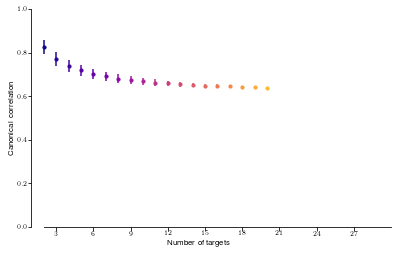

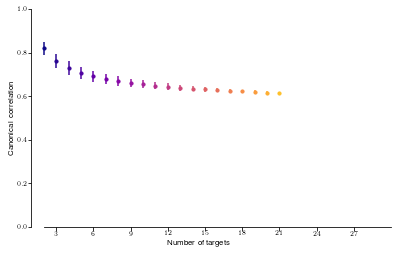

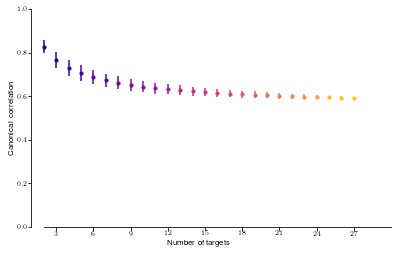

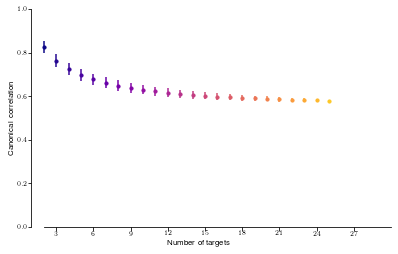

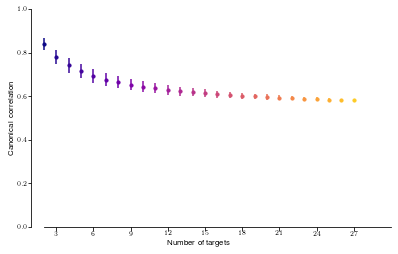

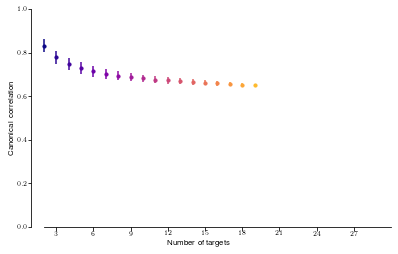

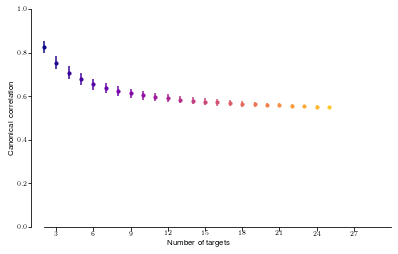

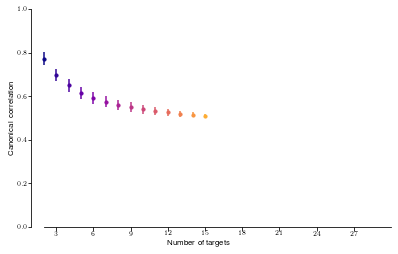

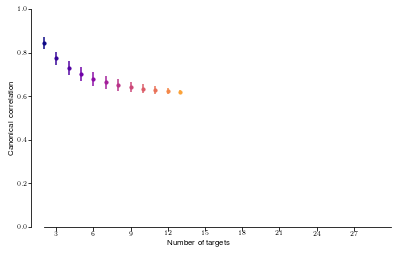

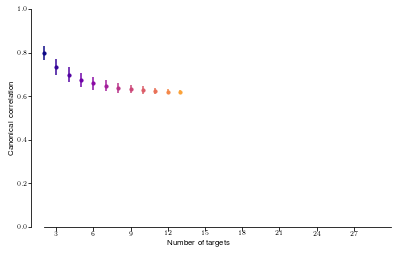

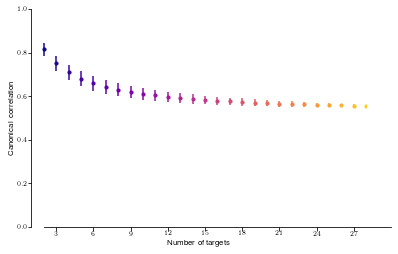

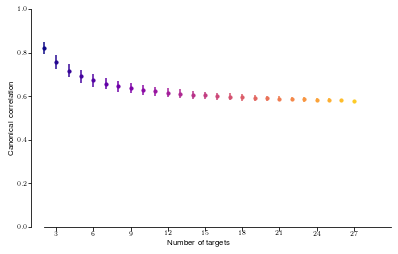

In [81]:
for i, allCCs_subset in enumerate(subset_CCs):
    fig, ax = plt.subplots()

    all_mean_ccs = [np.mean(x[:4],axis = 0) for x in allCCs_subset]
    mean_ccs = [np.mean(x) for x in all_mean_ccs]

    n_target_groups = len(mean_ccs)+2
    x = range(2, n_target_groups)
    colors = utility.get_colors(n_target_groups)

    for j, ccs in enumerate(all_mean_ccs):
        n_targets = j+2
        x = np.ones(len(ccs))*(n_targets)
        se = np.std(ccs)#/np.sqrt(len(ccs))
        plt.scatter(n_targets,np.mean(ccs), c = colors[j], s = 10)
        plt.errorbar(n_targets, np.mean(ccs), yerr = se, c = colors[j])
    plt.xlabel('Number of targets')
    plt.ylabel('Canonical correlation')
    plt.ylim([0,1])
    plt.xlim([1,28])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([2,30])
    ax.spines['left'].set_bounds([0,1])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    ex_file = paired_dfs[i][0]
    info = '_'.join([ex_file[:-4], str(defs.n_angle_groups), str(defs.min_trials_per_target), str(defs.match_mse_cutoff_perc)])
    plt.savefig("figures/mean_cca_subset_targets_std"+info+'.pdf', format= 'pdf')


### permutated targets

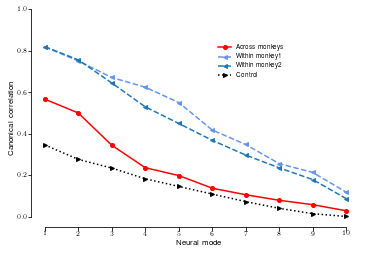

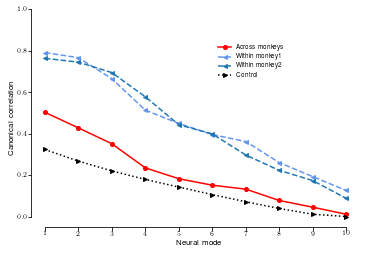

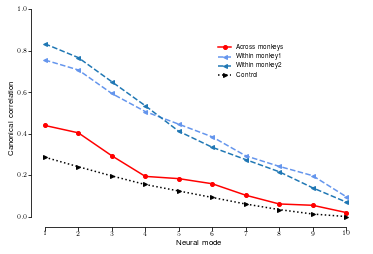

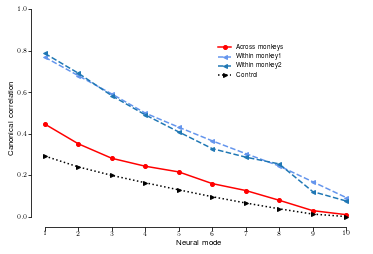

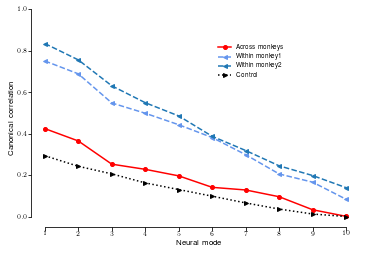

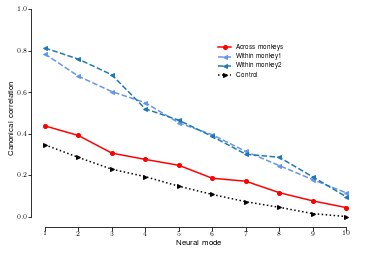

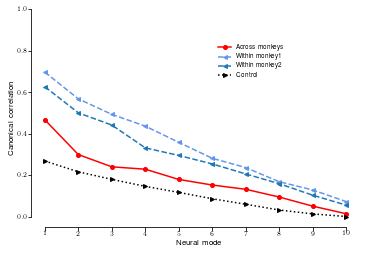

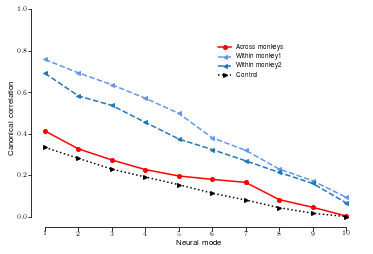

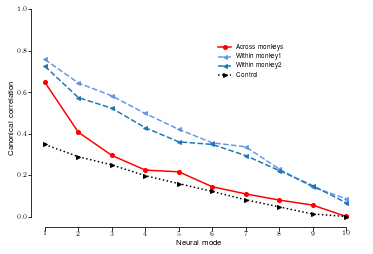

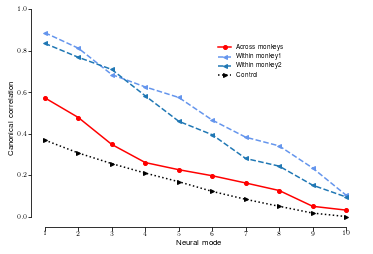

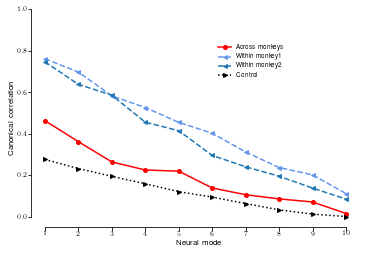

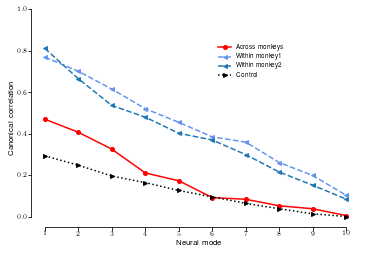

In [89]:
#test controls with shuffled targets
for ex_file, df1_, df2_ in paired_dfs:
    # df1_ = df1_.sample(frac = 1).reset_index() #shuffle rows
    # df1_.target_id = np.random.permutation(df1_.target_id.values) #shuffle all targets: lowers
    subset_target_groups = np.unique(df1_.target_group)
    
    #perform cca ################################################
    AllData1, AllData2 = defs.get_paired_data_arrays(df1_, df2_, epoch = defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
    shuffled_idx = np.random.permutation(np.arange(AllData1.shape[1])) #permutate targets: lowers
    AllData1[:] = AllData1[:,shuffled_idx,:,:,:]

    # print(AllData1.shape) #session x target_groups x trials x time x modes

    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T
        
    # lower bound
    len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))
    AllDataL1 = defs._get_data_array(df1_, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    AllDataL2 = defs._get_data_array(df2_, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllDataL1.shape,AllDataL2.shape),axis=0)
    CCsL=[]
    for sessionData1,sessionData2 in zip(AllDataL1,AllDataL2):
        r = []
        for n in range(params.n_iter * 10):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T
        
    # upper bound
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for session, sessionData in enumerate([AllData1[0], AllData2[0]]):
        r = []
        for n in range(params.n_iter * 10):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # plotting
    fig, ax = plt.subplots()
    x_ = np.arange(1,defs.n_components+1)
    ax.plot(x_, allCCs, color=params.colors.MainCC, marker = 'o', label=f'Across monkeys')
    ax.plot(x_, CCsU[:,0], color=params.colors.UpperCC, marker = '<', ls='--', label=f'Within monkey1')
    ax.plot(x_, CCsU[:,1], marker = '<', ls='--', label=f'Within monkey2')
    ax.plot(x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':', label=f'Control')


    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    # ax.set_title(f'{defs.areas[2]} Alignment')
    ax.legend(loc=(.55,.67))
    ax.set_ylabel('Canonical correlation')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,defs.n_components])
    ax.spines['left'].set_bounds([0,1])

    info = '_'.join([ex_file[:-4], str(len(subset_target_groups)), str(defs.n_angle_groups), str(defs.min_trials_per_target), str(defs.match_mse_cutoff_perc)])
    plt.savefig("figures/cca_permutated_"+info+'.pdf', format= 'pdf')

#### Behavioural correlation

In [46]:
@utility.report
def plot_monkey_cca_corr(paired_dfs):

    across_corrs_monkeys = defs.trim_across_monkey_corr(paired_dfs)
    CC_corr_monkey=[]

    # min_target_groups = np.inf
    # for _,df1_,_ in paired_dfs:
    #     n_groups = len(np.unique(df1.target_group))
    #     min_target_groups = np.min(min_target_groups, n_groups)

    #for each pair of sessions across monkeys
    for i, (_,df1_,df2_) in enumerate(paired_dfs):
        #get data for neural modes
        AllData1_monkey,AllData2_monkey = defs.get_paired_data_arrays(df1_, df2_, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
        # AllData2_monkey = defs.get_data_array(df2_, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
        _,_, min_trials_monkey, min_time_monkey,_ = np.min((AllData1_monkey.shape,AllData2_monkey.shape),axis=0)

        data1 = np.reshape(AllData1_monkey[:,:min_trials_monkey,:min_time_monkey,:], (-1,defs.n_components))
        data2 = np.reshape(AllData2_monkey[:,:min_trials_monkey,:min_time_monkey,:], (-1,defs.n_components))

        #get behavioral correlation
        behav = np.array(across_corrs_monkeys[i])
        # behav = behav[behav>params.Behav_corr_TH]

        #perform CCA
        CC_corr_monkey.append((dt.canoncorr(data1, data2)[:4].mean() , np.mean(behav)))
    CC_corr_monkey = np.array(CC_corr_monkey)
    
    #plotting
    fig, ax = plt.subplots()
    ax.scatter(CC_corr_monkey[:,1],CC_corr_monkey[:,0], color=params.colors.MonkeyPts, label='Monkeys', zorder=0)
    ax.set_xlabel('Behavioural correlation')
    ax.set_xlabel('MSE')
    ax.set_ylabel('Canonical correlation')
    # ax.set_ylim([.53,.85])
    # ax.spines['left'].set_bounds([.55,.85])
    # ax.set_xlim([.69,.95])
    # ax.spines['bottom'].set_bounds([.7,.95])
    # ax.legend(loc=(0,.8))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_major_formatter(FormatStrFormatter('$%0.2f$'))

    return CC_corr_monkey[:,1], CC_corr_monkey[:,0]

In [47]:
import random_walk.defs as defs
reload(defs)



<module 'random_walk.defs' from '/home/jcc319/multi_animal_alignment/random_walk/defs.py'>

Executed: `plot_monkey_cca_corr` in 4.5s


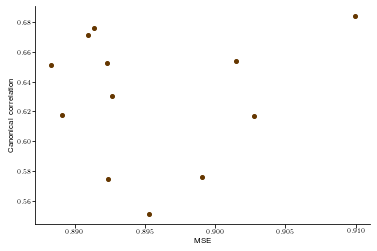

In [48]:
plot_monkey_cca_corr(paired_dfs);


<Figure size 432x288 with 0 Axes>

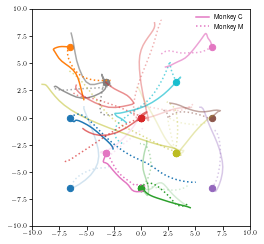

<Figure size 432x288 with 0 Axes>

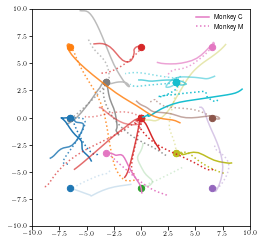

<Figure size 432x288 with 0 Axes>

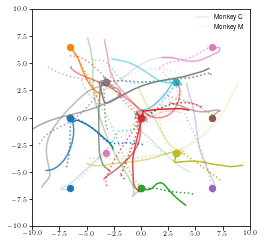

<Figure size 432x288 with 0 Axes>

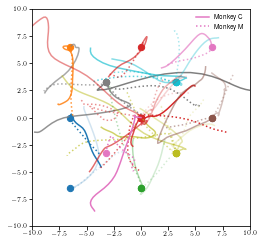

<Figure size 432x288 with 0 Axes>

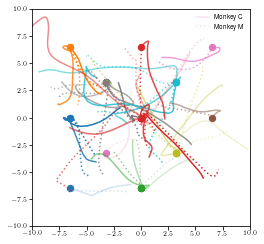

<Figure size 432x288 with 0 Axes>

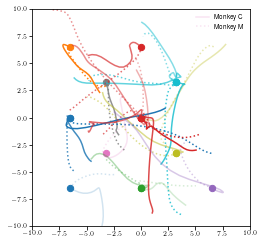

<Figure size 432x288 with 0 Axes>

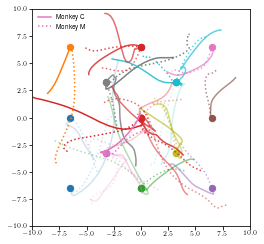

<Figure size 432x288 with 0 Axes>

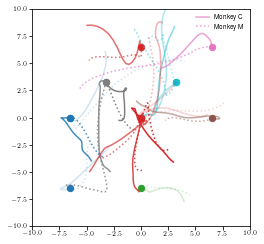

<Figure size 432x288 with 0 Axes>

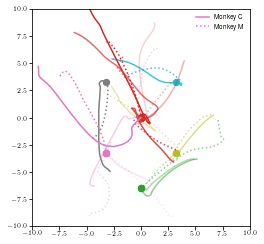

<Figure size 432x288 with 0 Axes>

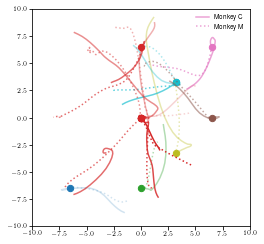

<Figure size 432x288 with 0 Axes>

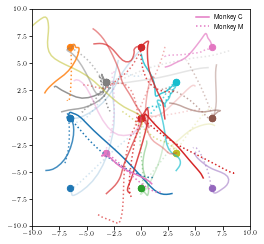

<Figure size 432x288 with 0 Axes>

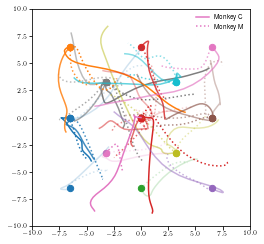

In [88]:
for ex_file, df1_, df2_ in paired_dfs[:]:
    #plot matched reaches
    plt.figure()
    ntrials = 10
    colors = utility.get_colors(13, 'tab10')
    alphas = np.linspace(0.2,1,defs.n_angle_groups)
    # alphas = np.ones(defs.n_angle_groups)
    target_groups = defs.target_groups
    plt.figure()
    df = df1_

    subset_target_groups = np.unique(df1_.target_group)

    center_ids = []
    for tar in subset_target_groups[:]:
        df1__ = df1_[df1_.target_group == tar]
        df2__ = df2_[df2_.target_group == tar]

        center_id = df2__.center_id.values[0]
        angle_group = df2__.angle_group.values[0]
        # if center_id in center_ids: continue #plot 1 target/center ID

        center_ids.append(center_id)
        center = df2__.center.values[0]
        plt.scatter(center[0], center[1], s = 40, c= colors[center_id])

        for i in range(1):
            pos = df1__.pos_centered.values[i]
            # pos = df1__.pos.values[i]
            # targets = df1__.target_centered.values[i]

            plt.plot(*pos[:].T, c=colors[center_id], label = 'Monkey C', alpha = alphas[angle_group])
            # plt.scatter(*targets[:].T, s = 10, c=colors[center_id])

            pos = df2__.pos_centered.values[i]
            # pos = df2__.pos.values[i]
            # targets = df2__.target_centered.values[i]
            plt.plot(*pos[:].T, c=colors[center_id], linestyle = 'dotted', label = 'Monkey M', alpha = alphas[angle_group])
            # plt.scatter(*targets[:].T, s = 10, c=colors[color_idx],marker = '^')
    plt.gca().set_aspect(1)
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    info = '_'.join([ex_file[:-4], str(len(subset_target_groups)), str(defs.n_angle_groups), str(defs.min_trials_per_target), str(defs.match_mse_cutoff_perc)])
    # plt.savefig("figures/paired_reaches_subset_targets"+info+'.pdf', format= 'pdf')
    plt.savefig("figures/paired_reaches_all_targets"+info+'.pdf', format= 'pdf')